In [5]:
pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import shap

In [11]:
import pandas as pd

# Step 1: Load your Excel dataset
df = pd.read_excel(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset.xlsx")

# Step 2: Create synthetic labels for LoanApproved
df['LoanApproved'] = (
    (df['Credit_Score'] > 650) &
    (df['Income'] > 60000) &
    (df['Loan_Amount'] < 400000)
).astype(int)

# Step 3: Save as a new CSV for training
df.to_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv", index=False)

print("✅ loan_access_dataset_with_labels.csv created successfully.")


✅ loan_access_dataset_with_labels.csv created successfully.


In [12]:
df = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")


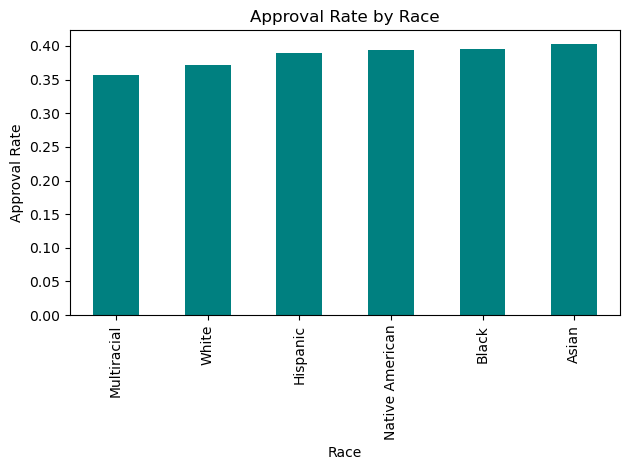

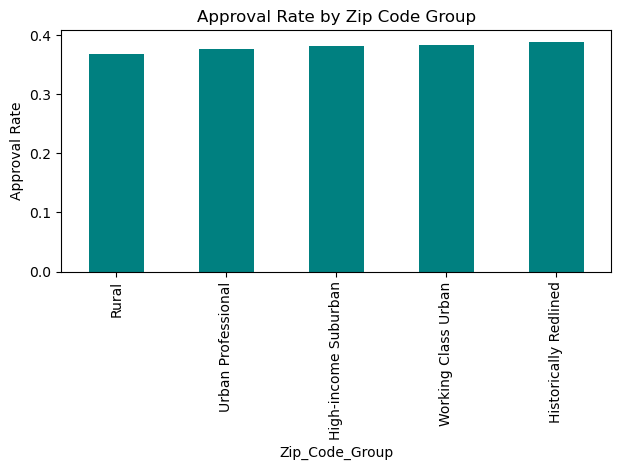

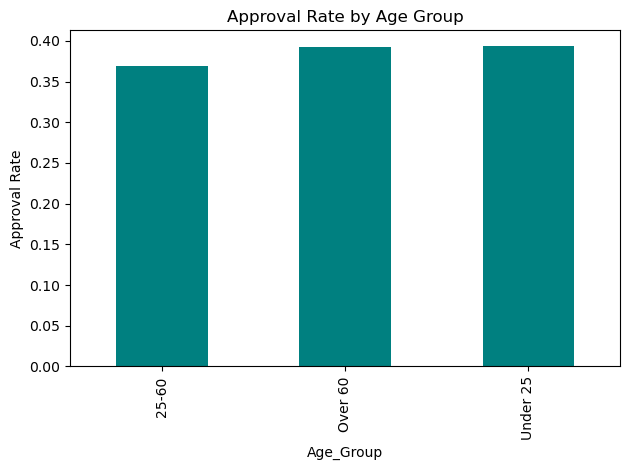

In [21]:
#📊 2. Approval Rate by Race, Zip_Code_Group, Age_Group
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original data again
df_vis = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")

# Plot helper
def plot_group_approval(group_col, title):
    approval_rates = df_vis.groupby(group_col)["LoanApproved"].mean().sort_values()
    approval_rates.plot(kind="bar", color="teal")
    plt.title(f"Approval Rate by {title}")
    plt.ylabel("Approval Rate")
    plt.tight_layout()
    plt.savefig(f"{group_col}_approval_rate.png")
    plt.show()

# Approval by Race
plot_group_approval("Race", "Race")

# Approval by Zip Code Group
plot_group_approval("Zip_Code_Group", "Zip Code Group")

# Approval by Age Group
plot_group_approval("Age_Group", "Age Group")


In [23]:
#📉 3. False Positive / False Negative Rate by Gender or Race
from sklearn.metrics import confusion_matrix

# Append predictions and actuals to test set
df_eval = df_vis.loc[X_test.index].copy()
df_eval["y_true"] = y_test.values
df_eval["y_pred"] = y_pred

# False Positive Rate by group
def false_rates_by_group(group_col):
    results = {}
    for group in df_eval[group_col].unique():
        group_df = df_eval[df_eval[group_col] == group]
        cm = confusion_matrix(group_df["y_true"], group_df["y_pred"], labels=[0,1])
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[0][0]
        TP = cm[1][1]
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        results[group] = {"FPR": round(fpr, 3), "FNR": round(fnr, 3)}
    return pd.DataFrame(results).T

false_rates_by_group("Race")


,FPR,FNR
Hispanic,0.260,0.291
White,0.139,0.363
Black,0.306,0.274
Asian,0.297,0.086
Multiracial,0.150,0.067
Native American,0.250,0.250


In [24]:
#📏 3. Disparate Impact & Equal Opportunity (Fairness Metrics)
def disparate_impact(df, protected_attr):
    # P(ŷ=1 | unprivileged) / P(ŷ=1 | privileged)
    groups = df[protected_attr].unique()
    rates = {}
    for group in groups:
        rate = df[df[protected_attr] == group]["LoanApproved"].mean()
        rates[group] = rate
    privileged = max(rates, key=rates.get)
    unprivileged = min(rates, key=rates.get)
    DI = rates[unprivileged] / rates[privileged] if rates[privileged] > 0 else 0
    return {
        "Privileged": privileged,
        "Unprivileged": unprivileged,
        "DI Ratio": round(DI, 3),
        "Rates": rates
    }

# Example for Gender
disparate_impact(df_vis, "Gender")


{'Privileged': 'Male',
 'Unprivileged': 'Non-binary',
 'DI Ratio': 0.826,
 'Rates': {'Female': 0.37433808553971487,
  'Male': 0.3875588295477798,
  'Non-binary': 0.32019704433497537}}

In [25]:
#✅ PART B: SHAP Visualizations
!pip install shap


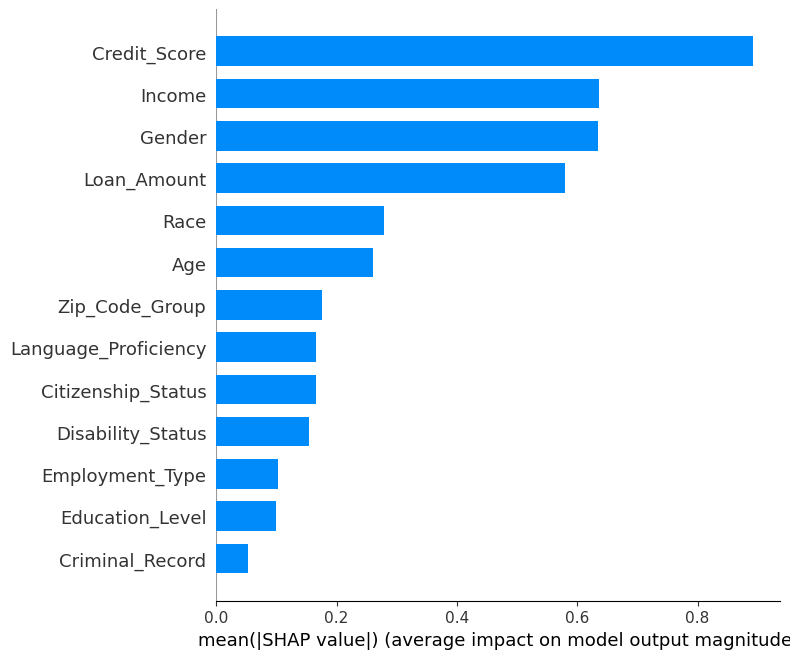

In [26]:
#📊 1. Global SHAP Summary Plot
import shap

# Initialize SHAP explainer for logistic regression
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


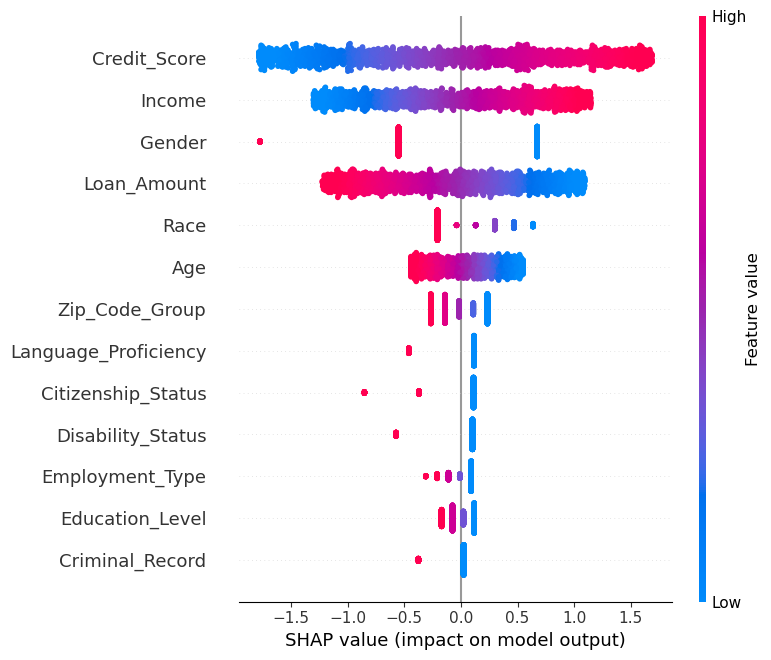

In [27]:
#📈 2. Detailed SHAP Beeswarm Plot (Feature Impact by Sample)
shap.summary_plot(shap_values, X_test)


In [29]:
import shap
shap.initjs()


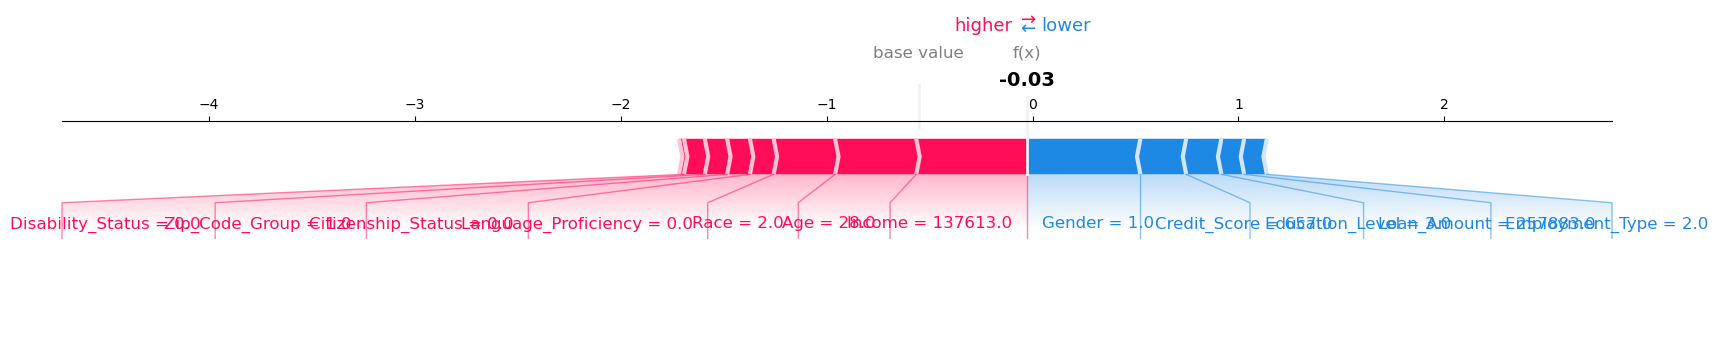

<Figure size 640x480 with 0 Axes>

In [33]:
#🔍 3. SHAP Force Plot for a Single Example
i = 0  # Change to any row number in X_test
shap.plots.force(shap_values[i], matplotlib=True)
plt.savefig("shap_force_plot.png")


In [15]:
#🧼 2. Preprocess & Encode Categorical Columns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop ID column (not useful for prediction)
df = df.drop(columns=["ID", "Age_Group"])

# Encode categorical features
categorical_cols = df.select_dtypes(include="object").columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Split into features and target
X = df.drop("LoanApproved", axis=1)
y = df["LoanApproved"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#📥 1. Load Labeled Data
import pandas as pd

# Load the dataset with synthetic labels
df = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")

df.head()


,ID,Gender,Race,Age,Age_Group,Income,Credit_Score,Loan_Amount,Employment_Type,Education_Level,Citizenship_Status,Language_Proficiency,Disability_Status,Criminal_Record,Zip_Code_Group,LoanApproved
0,1,Female,White,74,Over 60,112117,641,378691,Full-time,Graduate,Citizen,Fluent,No,No,High-income Suburban,0
1,2,Female,White,36,25-60,155943,664,441856,Self-employed,High School,Permanent Resident,Limited,No,No,Urban Professional,0
2,3,Female,White,27,25-60,130933,550,401760,Full-time,Graduate,Citizen,Fluent,No,No,Urban Professional,0
3,4,Male,White,67,Over 60,165816,804,159264,Gig,Some College,Citizen,Fluent,No,No,Urban Professional,1
4,5,Male,Multiracial,57,25-60,81510,694,256742,Full-time,Some College,Visa Holder,Fluent,No,No,Rural,1


In [16]:
#🤖 3. Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1238
           1       0.69      0.69      0.69       762

    accuracy                           0.76      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.76      0.76      0.76      2000



C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


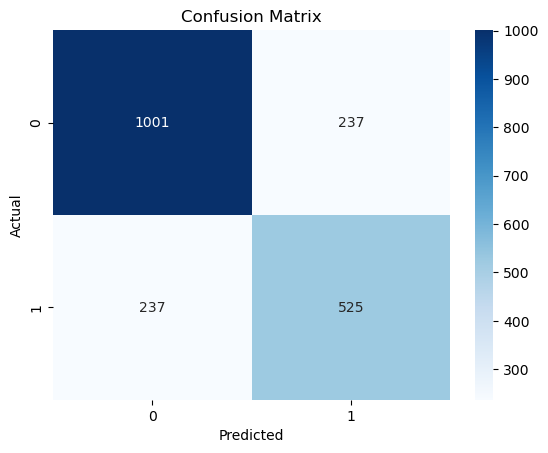

In [17]:
#📉 4. Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


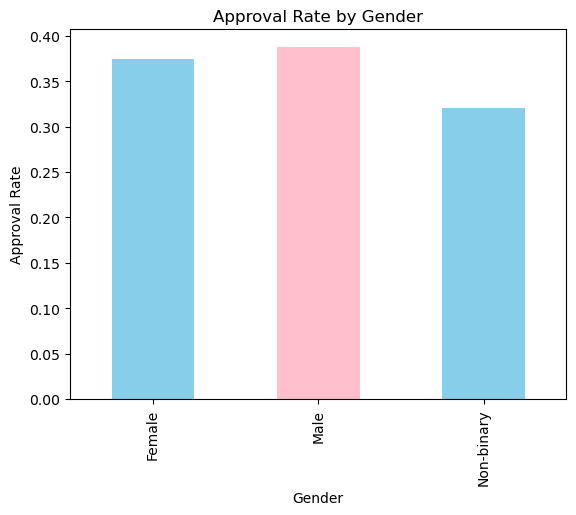

In [18]:
#📊 5. Approval Rate by Gender (Bias Visualization)
# Load original data again (with strings)
df_vis = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")

# Group-wise approval rates
approval_by_gender = df_vis.groupby("Gender")["LoanApproved"].mean()

approval_by_gender.plot(kind="bar", color=["skyblue", "pink"])
plt.title("Approval Rate by Gender")
plt.ylabel("Approval Rate")
plt.savefig("bias_visualization.png")
plt.show()


In [19]:
#📝 6. Save Submission File
submission = pd.DataFrame({
    "ID": df_vis.loc[X_test.index, "ID"],
    "LoanApproved": y_pred
})
submission.to_csv(r"D:\Aditya\Github\AI Bias Bounty\submission.csv", index=False)
print("✅ submission.csv saved.")


✅ submission.csv saved.


In [3]:
#✅ Step 1: Retrain the Model Using Training Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# Load the training dataset (with labels)
train_df = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")

# Drop non-essential columns
train_df = train_df.drop(columns=["ID", "Age_Group"])

# Encode categorical columns
categorical_cols = train_df.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

# Split into X and y
X = train_df.drop("LoanApproved", axis=1)
y = train_df["LoanApproved"]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("✅ Model retrained.")


✅ Model retrained.


C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
#✅ Step 2: Load & Preprocess the Official test.csv
# Load the official test file
test_df = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\test.csv")

# Drop unused column
test_df = test_df.drop(columns=["Age_Group"])

# Encode categorical columns
categorical_cols = test_df.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])

# Drop ID column for prediction
X_test_submission = test_df.drop("ID", axis=1)


In [5]:
#✅ Step 3: Predict and Save submission.csv
# Predict on test set
predictions = model.predict(X_test_submission)

# Create submission dataframe
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "LoanApproved": predictions
})

# Save the output
submission.to_csv(r"D:\Aditya\Github\AI Bias Bounty\submission.csv", index=False)

print("📤 submission.csv generated successfully.")


📤 submission.csv generated successfully.


In [6]:
#🔍 Step 1: Reconstruct df_val With True & Predicted Labels
# Get original validation data (for fairness analysis)
val_df = X_val.copy()
val_df["LoanApproved"] = y_val.values
val_df["Predicted"] = model.predict(X_val)


In [7]:
#📊 Step 2: Group-Wise Approval & Error Rates
# Load raw labeled data again for full attribute context
df_full = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\loan_access_dataset_with_labels.csv")

# Merge validation predictions with demographics
val_ids = X_val.index
df_val = df_full.loc[val_ids].copy()
df_val["y_true"] = y_val.values
df_val["y_pred"] = model.predict(X_val)

# Function: calculate FPR and FNR by group
from sklearn.metrics import confusion_matrix

def error_rates_by_group(df, group_col):
    results = {}
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        cm = confusion_matrix(subset["y_true"], subset["y_pred"], labels=[0,1])
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[0][0]
        TP = cm[1][1]
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        results[group] = {"FPR": round(fpr, 3), "FNR": round(fnr, 3)}
    return pd.DataFrame(results).T

# Run this for Race and Gender
error_rates_by_group(df_val, "Race")


,FPR,FNR
Hispanic,0.260,0.291
White,0.139,0.363
Black,0.306,0.274
Asian,0.297,0.086
Multiracial,0.150,0.067
Native American,0.250,0.250


In [8]:
#⚖️ Step 3: Disparate Impact (DI) & Equal Opportunity Diff (EOD)
def disparate_impact(df, group_col):
    # Approval rates per group
    approval_rates = df.groupby(group_col)["y_pred"].mean()
    privileged = approval_rates.idxmax()
    unprivileged = approval_rates.idxmin()
    di_ratio = round(approval_rates[unprivileged] / approval_rates[privileged], 3)
    return {
        "Privileged": privileged,
        "Unprivileged": unprivileged,
        "DI Ratio": di_ratio,
        "Approval Rates": approval_rates.to_dict()
    }

def equal_opportunity_diff(df, group_col):
    # TPR per group = TP / (TP + FN)
    tpr_by_group = {}
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        cm = confusion_matrix(subset["y_true"], subset["y_pred"], labels=[0,1])
        TP = cm[1][1]
        FN = cm[1][0]
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        tpr_by_group[group] = round(tpr, 3)
    eod = max(tpr_by_group.values()) - min(tpr_by_group.values())
    return {
        "TPR by group": tpr_by_group,
        "Equal Opportunity Difference": round(eod, 3)
    }

# Example: Race and Gender
disparate_impact(df_val, "Race")
equal_opportunity_diff(df_val, "Race")


{'TPR by group': {'Hispanic': 0.709,
  'White': 0.637,
  'Black': 0.726,
  'Asian': 0.914,
  'Multiracial': 0.933,
  'Native American': 0.75},
 'Equal Opportunity Difference': 0.296}

In [9]:
#⚖️ Threshold Adjustment – Mitigation Strategy
#Instead of predicting LoanApproved = 1 if prob ≥ 0.5, we’ll try a different threshold (e.g. 0.6) and observe how disparate impact changes.
from sklearn.metrics import confusion_matrix, accuracy_score

# Get probability scores from model
y_probs = model.predict_proba(X_val)[:, 1]

# Try a new threshold (e.g., 0.6 instead of 0.5)
threshold = 0.6
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Update df_val
df_val["y_pred_adjusted"] = y_pred_adjusted

# Accuracy drop?
print("Original Accuracy:", accuracy_score(df_val["y_true"], df_val["y_pred"]))
print("Adjusted Threshold Accuracy:", accuracy_score(df_val["y_true"], df_val["y_pred_adjusted"]))


Original Accuracy: 0.763
Adjusted Threshold Accuracy: 0.7745


In [10]:
#🧪 Recalculate Fairness Metrics (After Mitigation)
# Replace y_pred with adjusted version for fairness check
df_val["y_pred"] = df_val["y_pred_adjusted"]

# Re-run fairness audits
print("🎯 Fairness After Mitigation:\n")
print(disparate_impact(df_val, "Race"))
print(equal_opportunity_diff(df_val, "Race"))


🎯 Fairness After Mitigation:

{'Privileged': 'Asian', 'Unprivileged': 'Native American', 'DI Ratio': 0.414, 'Approval Rates': {'Asian': 0.48360655737704916, 'Black': 0.38095238095238093, 'Hispanic': 0.33055555555555555, 'Multiracial': 0.45714285714285713, 'Native American': 0.2, 'White': 0.2402972749793559}}
{'TPR by group': {'Hispanic': 0.624, 'White': 0.526, 'Black': 0.642, 'Asian': 0.81, 'Multiracial': 0.933, 'Native American': 0.5}, 'Equal Opportunity Difference': 0.433}


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 🔍 Load the official test set
test_df = pd.read_csv(r"D:\Aditya\Github\AI Bias Bounty\test.csv")

# 🔧 Drop unused columns (optional)
if "Age_Group" in test_df.columns:
    test_df = test_df.drop(columns=["Age_Group"])

# 🎯 Encode categorical columns like training
test_encoded = test_df.copy()
categorical_cols = test_encoded.select_dtypes(include="object").columns

for col in categorical_cols:
    le = LabelEncoder()
    test_encoded[col] = le.fit_transform(test_encoded[col].astype(str))

# 🚨 Drop ID before prediction
X_test_submission = test_encoded.drop("ID", axis=1)

# 🤖 Predict using trained model
predictions = model.predict(X_test_submission)

# 📤 Create submission DataFrame
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "LoanApproved": predictions
})

# 💾 Save as submission.csv
submission.to_csv(r"D:\Aditya\Github\AI Bias Bounty\submission.csv", index=False)

print("✅ Final submission.csv saved successfully.")


✅ Final submission.csv saved successfully.
